# About the dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Convolutional Neural Network application for classification
First, I'll import fastai library for computer vision and then import the metrics library as well, in order to monitor the error rate of our deeplearning application.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 8 # Modify according to VRAM on computer's gpu

The dataset is downloaded from https://www.cs.toronto.edu/~kriz/cifar.html.

In [4]:
path = untar_data(URLs.CIFAR)
print(path)

/home/santiago/.fastai/data/cifar10


Next up, obsere what kind of data the downloaded dataset offers. By doing this, it will be easy to determine which of the different techniques offered in the fastai library will be used later in the code.

In [22]:
path.ls()

[PosixPath('/home/santiago/.fastai/data/cifar10/train'),
 PosixPath('/home/santiago/.fastai/data/cifar10/models'),
 PosixPath('/home/santiago/.fastai/data/cifar10/test'),
 PosixPath('/home/santiago/.fastai/data/cifar10/labels.txt')]

Since the provided dataset has already a test and a train folder each containing folders with the associated labels for each image as its name, it is a matter of associating those pictures to their respective labels as well as creating a _databunch_ type to contain both train and validation datasets.

Two functions are used in this bit of code. _get_trasforms_ and _ImageDataBunch_. 

In [6]:
tfms = get_transforms(do_flip = False)
data = ImageDataBunch.from_folder(path, train = 'train', valid = 'test', ds_tfms = tfms, size = 255)

It is important to remember that this dataset contains very small, very low resolution pictures of different animals and types of transportation vehicles. Sometimes, even for the human eye, it is quite difficult to recognize what is in every picture. That said, the next bit of code will display some of the pictures to illustrate that statement.

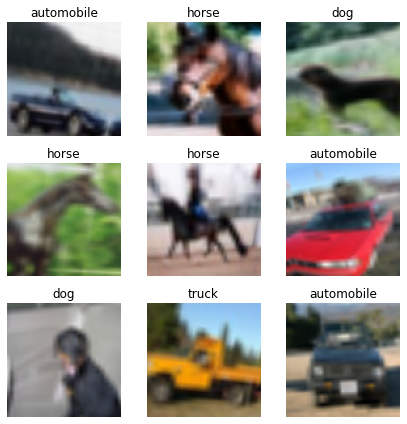

In [7]:
data.show_batch(rows = 3, figsize = (6,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(10, 10)

For datasets of this kind, there shouldn't be a big gap between resnet34 and resnet50. In fact, prior to doing this document, I indeed trained a resnet50 and got worse results than the ones presented here. Our convolutional neural network function takes the databunch created earlier, the kind of topology we want for our cnn and the metric we want to display. As we only imported the error_rate metric, that is the one we will be using.

In [9]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

As the GTX 960M 4GB I'm using is already a bit old and the dataset is quite big, I will first learn for only two epochs using the default learning rate, then I'll plot the learning rate against the train loss in order to find out if fr further training it would be worth to change said learning rate for better convergence.

In [10]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.373255,0.219069,0.075200,12:38
1,0.275616,0.173301,0.062600,13:25


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


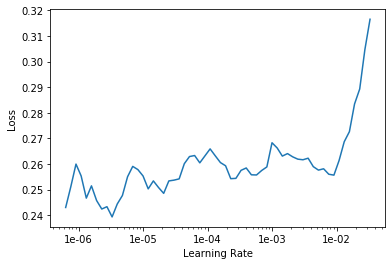

In [11]:
learn.lr_find()
learn.recorder.plot()

As the graph shows, the loss is somewhat constant in the interval between 1e-06 and 1e-02, so I'll choose a slice between that interval for some more training.

In [12]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.235766,0.152675,0.053800,18:44
1,0.189654,0.140831,0.049600,18:24


The extra training paid off and that got the error rate almost 3% down from an already good classifier. As I stated earlier, some of these pictures are hard to classify even for the human eye. Next up, I'll plot some of the pictures for which the model was very confused when classifying so that the reader can appreciate the difficulty of identifying said pictures and so that the feature cnn networks imply which is automatic pattern recognition.

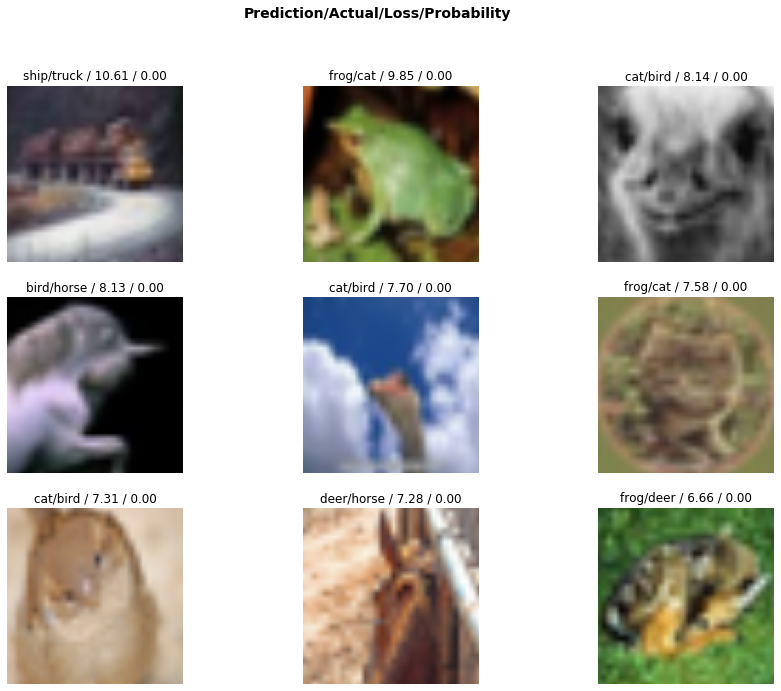

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

Now that the model seems pretty well trained, it is time to see how it performs in general. For this, I'll plot the confusion matrix as well as the classes for which the model got most confused. 

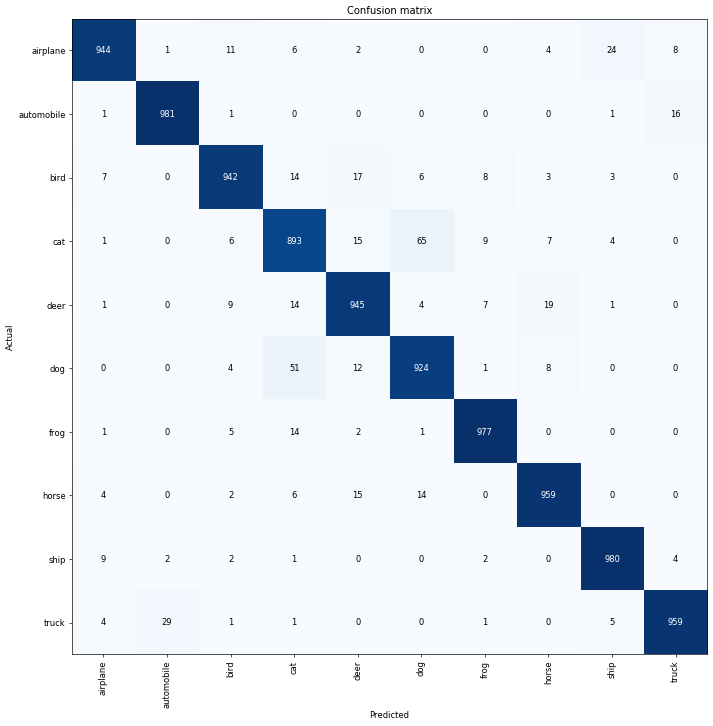

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
interp.most_confused(min_val=20)

[('cat', 'dog', 65),
 ('dog', 'cat', 51),
 ('truck', 'automobile', 29),
 ('airplane', 'ship', 24)]

Above, the overall performance of the trained model is shown. According to the confusion matrix and the error rate rating, the model has an overall accuracy of 95.04 % and an overall error rate of 4.96 % which is pretty good for an image classifier given the CIFAR dataset. The most confused classes are cats and dogs, which makes sense since the shapes of both animals are pretty similar with images this scale.

In [16]:
learn.save('stage-1')

Finally, I will train for a couple of epochs using a new criteria. This time I'll use the lowest train loss an error_rate returns to see if the trade-off is worth the trouble.

In [18]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,3e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.166405,0.136463,0.048800,17:49
1,0.168223,0.134991,0.049000,18:33


In [19]:
learn.save('stage-1')

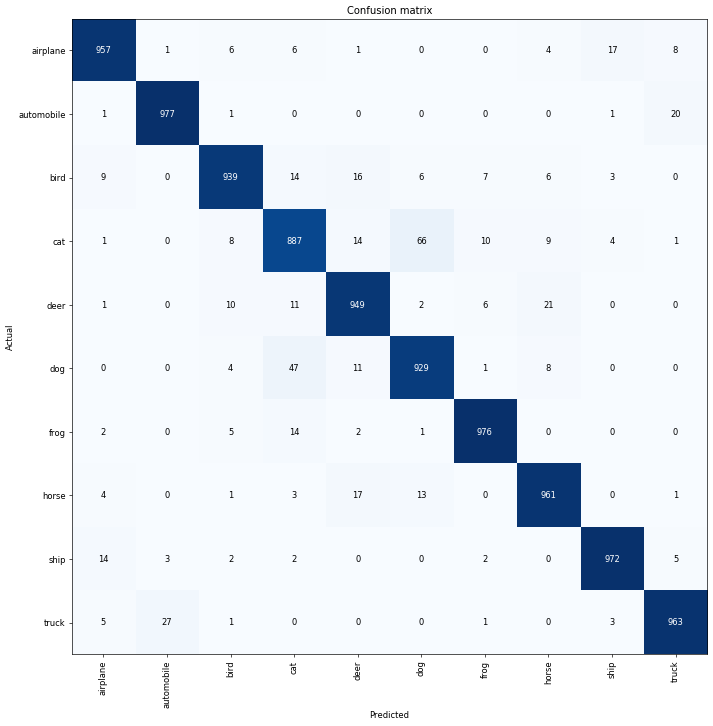

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=20)

[('cat', 'dog', 66),
 ('dog', 'cat', 47),
 ('truck', 'automobile', 27),
 ('deer', 'horse', 21),
 ('automobile', 'truck', 20)]

The new confusion chart shows that the trade-off was not worth it and that the overall accuracy was improved by only 0.47 %. The classes for which the trained model is confused the most are still cats and dogs. The instances where the confusion for when the model classifies the image as a dog, but was a cat has increased, nevertheless, the contrary case has decreased.